In [1]:
import numpy as np

# Generate a random MPS

In [2]:
def random_mps(num_sites, local_dim, bond_dim, seed=31415):
    """
    Function to generate a random MPS
    The left and right most legs are dummy legs of dimension 1.
    They are included to insure that all tensors are rank-3.
    """
    np.random.seed(seed)

    assert num_sites > 2, 'The number of site should be > 2'
        
    mps = []
    for i in range(num_sites):
        if i == 0:
            M = np.random.rand(1, local_dim, bond_dim)
        elif i == num_sites-1:
            M = np.random.rand(bond_dim, local_dim, 1)
        else:
            M = np.random.rand(bond_dim, local_dim, bond_dim)
        mps.append(M)
    return mps

In [3]:
N = 50   # number of sites
d = 4    # local space dimenision
D = 30   # bond dimension
seed = 7 # random seed

mps = random_mps(N, d, D, seed)

print('Number of sites : %d' % len(mps))
print('Dimensions of the first, second and the last tensors: %s, %s, %s'\
      % (mps[0].shape, mps[1].shape, mps[-1].shape))

Number of sites : 50
Dimensions of the first, second and the last tensors: (1, 4, 30), (30, 4, 30), (30, 4, 1)


<center>
    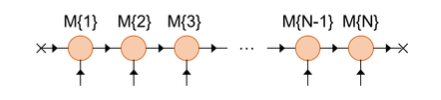
</center>

# Utility function to check if a MPS is properly normalized

In [4]:
def is_normalized(mps, normalization, tol=1e-10, verbose=False):
    
    assert normalization in ('left', 'right'), f'Unknown normalization {normalization}'
    
    bad_sites = {}
    
    N = len(mps)
    
    for i in range(N):
        A = mps[i]
        u, v, w = A.shape
        if normalization == "right":
            A = A.reshape(u, -1) 
        else:
            A = A.reshape(-1, w)
            A = A.T
        delta = np.max(abs(A @ A.T - np.eye(A.shape[0]))).reshape(-1,1)
        if  delta > tol:
            bad_sites[i] = delta

    if bad_sites:
        if verbose:
            for i,tol in bad_sites.items():
                print(f'Bad approximation for {i}-th site - {delta.item()}')
        return False
    else:
        print('You MPS is normalized correctly')
    
    return True        

# Transform to left-canonical form

In [5]:
def left_normalize(mps, idx=-1, D_max=np.inf, verbose=False):
    """
    In place normalization of an MPS to left canonical form
    
    Input:
    ------
        mps:    A list of tensors representing an MPS.
        idx:    A site index which is used to stop the propagation of the normalization.
                Default values: -1. A full right sweep will be perfomed.
        
    """
    # length of the MPS
    N = len(mps)
    
    # determine where to stop
    if idx == -1:
        stop = N
    else:
        assert 0 < idx < N-1, 'The stoping site index must be 0 < idx < N-1'
        stop = idx

    assert D_max > 0, 'Please, specify a correct D_max'
      
    if verbose:
        print(f'Performing left normalization for sites {list(range(stop))}')
        
    for i in range(stop):
        # get the current tensor
        M = mps[i]
        # reshape into a matrix by merging left/bottom legs
        u,v,w = M.shape
        M = M.reshape(u*v, w)
        # perform SVD
        U, s, Vh = np.linalg.svd(M, full_matrices=False)
        # assign the current tensor to U and reshape
        mps[i] = U.reshape(U.shape[0] // v, v, U.shape[1])
        if i < N:
            M_next = mps[i+1].reshape(Vh.shape[1], -1)
            mps[i+1] = (np.diag(s) @ Vh @ M_next).reshape(U.shape[1], v, -1)
    
    return

In [6]:
N = 5   # number of sites
d = 4    # local space dimenision
D = 30   # bond dimension
seed = 7 # random seed

mps = random_mps(N, d, D, seed)

In [7]:
print(list(map(np.shape, mps)))

[(1, 4, 30), (30, 4, 30), (30, 4, 30), (30, 4, 30), (30, 4, 1)]


In [8]:
left_normalize(mps, 3, verbose=True)

Performing left normalization for sites [0, 1, 2]


In [9]:
is_normalized(mps, normalization='left', verbose=True)

Bad approximation for 3-th site - 36.63108505855951
Bad approximation for 4-th site - 36.63108505855951


False

In [10]:
print('Resulting MPS:\n', list(map(np.shape, mps)))

Resulting MPS:
 [(1, 4, 4), (4, 4, 16), (16, 4, 30), (30, 4, 30), (30, 4, 1)]


# Transform to right-canonical form

In [11]:
def right_normalize(mps, idx=-1, D_max=np.inf, verbose=False):
    """
    In place normalization of an MPS to right canonical form
    
    Input:
    ------
        mps:    A list of tensors representing an MPS.
        idx:    A site index which is used to stop the propagation of the normalization.
                Default values: -1. A full left sweep will be perfomed.
        
    """
    # length of the MPS
    N = len(mps)
    
    # assertions
    if idx == -1:
        stop = 0
    else:
        assert 0 < idx < N-1, 'The stoping index must be 0 < idx < N-1'
        stop = idx
    
    assert D_max > 0, 'Please, specify a correct D_max'
    
    # determine where to stop
    stop = idx
    
    if verbose:
        print(f'Performing right normalization for sites {list(range(N-1, stop, -1))}')

    for i in range(N-1, stop, -1):
        M = mps[i]
        u,v,w = M.shape
        M = M.reshape(u, v*w)
        U, s, Vh = np.linalg.svd(M, full_matrices=False)
        
        mps[i] = Vh.reshape(Vh.shape[0], v, Vh.shape[1] // v)
        if i > 0:
            M_new = mps[i-1].reshape(-1, U.shape[0])
            mps[i-1] = (M_new @ U @ np.diag(s)).reshape(-1, v, Vh.shape[0])    

    return

In [12]:
N = 5   # number of sites
d = 4    # local space dimenision
D = 30   # bond dimension
seed = 70 # random seed

mps = random_mps(N, d, D, seed)

In [13]:
right_normalize(mps, 3, verbose=True)

Performing right normalization for sites [4]


In [14]:
is_normalized(mps, normalization='right', verbose=True)

Bad approximation for 0-th site - 1.1102230246251565e-15
Bad approximation for 1-th site - 1.1102230246251565e-15
Bad approximation for 2-th site - 1.1102230246251565e-15
Bad approximation for 3-th site - 1.1102230246251565e-15


False

In [15]:
list(map(np.shape, mps))

[(1, 4, 30), (30, 4, 30), (30, 4, 30), (30, 4, 4), (4, 4, 1)]

# Transform to site canonical form

In [16]:
def site_normalize(mps, idx, D_max=np.inf, verbose=False):
    """
    In-place normalization of an MPS to site canonical form
    """
    left_normalize(mps, idx, D_max, verbose)
    right_normalize(mps, idx, D_max, verbose)

    return

In [17]:
N = 5   # number of sites
d = 4    # local space dimenision
D = 30   # bond dimension
seed = 70 # random seed

mps = random_mps(N, d, D, seed)

In [18]:
site_normalize(mps, 3, verbose=True)

Performing left normalization for sites [0, 1, 2]
Performing right normalization for sites [4]


In [19]:
is_normalized(mps, 'left', verbose=True)

Bad approximation for 3-th site - 3.0000000000000018
Bad approximation for 4-th site - 3.0000000000000018


False

In [20]:
is_normalized(mps, 'right', verbose=True)

Bad approximation for 0-th site - 1.1102230246251565e-15
Bad approximation for 1-th site - 1.1102230246251565e-15
Bad approximation for 2-th site - 1.1102230246251565e-15
Bad approximation for 3-th site - 1.1102230246251565e-15


False

# Transform to bond-canonical form

In [21]:
N = 5   # number of sites
d = 4    # local space dimenision
D = 30   # bond dimension
seed = 70 # random seed

mps = random_mps(N, d, D, seed)

In [22]:
def bond_normalize(mps, idx, D_max=np.inf, verbose=False):
    """
    In-place normalization of an MPS to bond canonical form
    """
    left_normalize(mps, idx, D_max, verbose)
    right_normalize(mps, idx, D_max, verbose)
    
    M = mps[idx]
    u,v,w = M.shape
    M = M.reshape(u*v,w)
    # perform SVD
    U, s, Vh = np.linalg.svd(M, full_matrices=False)

    mps[idx] = U.reshape(U.shape[0] // v, v, U.shape[1])

    M_next = mps[idx+1].reshape(Vh.shape[1], -1)
    mps[idx+1] = (Vh @ M_next).reshape(Vh.shape[0],v,-1)

    return s, (idx, idx+1)

In [23]:
s, (left_idx, right_idx) = bond_normalize(mps, 2)

In [24]:
print(list(map(np.shape, mps)))

[(1, 4, 4), (4, 4, 16), (16, 4, 16), (16, 4, 4), (4, 4, 1)]


In [25]:
is_normalized(mps, 'right', verbose=True)

Bad approximation for 0-th site - 1.1102230246251565e-15
Bad approximation for 1-th site - 1.1102230246251565e-15
Bad approximation for 2-th site - 1.1102230246251565e-15


False

In [26]:
is_normalized(mps, 'left', verbose=True)

Bad approximation for 3-th site - 3.0000000000000018
Bad approximation for 4-th site - 3.0000000000000018


False

# Exercise 1

In [27]:
from copy import deepcopy

def canonical_form(mps, idx, n_keep=np.inf):
    """
    Get the canonical form of the MPS represented as a list of tensors of size N.
    Brings the tensors M{0},..,M{idx-1} in the input MPS into the left canonical
    form, and the other M{idx},..,M{N-1} into the right canonical form.
    Each element of the input MPS is a rank-3 tensor,

    Input
    -----
        mps:     An MPS of length N. Each cell element is a rank-3
                 tensor, where the first, second, and third dimensions are
                 associated with left, bottom (i.e., local), and right legs,
                 respectively.               
        idx:     Index for the bond connecting the tensors M{idx-1} and
                 M{idx}. With respect to the bond, the tensors to the left
                 (right) are brought into the left-(right-)canonical form. If id ==
                 0, the whole MPS will be in the right-canonical form.
        n_keep:  Maximum bond dimension. That is, only n_keep the
                 singular values and their associated singular vectors are kept at
                 each iteration.
    Output
    ------
        cmps:   s Left-, right-, or bond-canonical form from input M,
                 depending on id, as follows:
                 * idx == 0: right-canonical form
                 * idx == len(mps): left-canonical form
                 * otherwise: bond-canonical form

        s:       Singular values at the bond between M{id} and M{id+1}. 
        dw:      Discarded weight (i.e., the sum of the square of the singular  
                 values that are discarded) at the bond between M{n} and M{n+1.
                 Is a cector of length len(MPS) - 1.
    """
    assert isinstance(idx, int), 'The bond index must be an integer'
    assert 0 <= idx <= len(mps)-1, 'The input bond index must be 0 <= idx <= len(mps)-1'
    assert mps[0].shape[0]==1, 'The dimension of the first tensor must be 1'
    assert mps[-1].shape[-1] == 1, 'The dimension of last tensor must be 1'
        
    N = len(mps)
    
    if idx == 0: idx -= 1  # need to adjust the index to traverse properly
    
    # init discard weight
    dw = np.zeros(len(mps)-1)
              
    # left canonical form of M{0}...M(idx-1)       
    for i in range(0, idx+1, 1):
        M = mps[i]
        n, d, D = M.shape
        M = M.reshape(n*d, D)
        U, s, V = np.linalg.svd(M, full_matrices=False)
            
        # truncating the bond dimention
        keep = min(n_keep, len(s))
        U = U[:,:keep]
        s, err = s[:keep], s[keep:]
        V = V[:keep,:]
        
        mps[i] = U.reshape(U.shape[0] // d, d, U.shape[1])
        
        if i < idx:
            print(i, "L")
            dw[i] = np.sum(err**2)
            M̃ = mps[i+1].reshape(D, -1)
            mps[i+1] = (np.diag(s) @ V @ M̃).reshape(U.shape[1], d, -1)
        else:
            R1 = np.diag(s) @ V
            print(i, 'R1')

        
    # right canonical form of M{N-1}...M(idx)
    for i in range(N-1, idx, -1):
                
        M = mps[i]
        D, d, n = M.shape
        M = M.reshape(D, n*d)
        U, s, V = np.linalg.svd(M, full_matrices=False)

        # truncating the bond dimention
        keep = min(n_keep, len(s))
        U = U[:,:keep]
        s, err = s[:keep], s[keep:]
        V = V[:keep,:] 

        mps[i] = V.reshape(V.shape[0], d, V.shape[1] // d)

        if i > idx+1:
            print(i, "R")
            dw[i-1] = np.sum(err**2) 
            M̃ = mps[i-1].reshape(-1, D)
            mps[i-1] = (M̃ @ U @ np.diag(s)).reshape(-1, d, V.shape[0])
        else:
            R2 = U @ np.diag(s)
            print(i, 'R2')

    if idx+1 == 0:
        s = R2
    elif idx == N-1:
        s = R1
    else:
        U, s, V = np.linalg.svd(R1 @ R2, full_matrices=False)

        # truncating the bond dimention
        keep = min(n_keep, len(s))
        U = U[:,:keep]
        V = V[:keep,:]
        
        mps[idx-1] = mps[idx-1] @ U
        mps[idx] = (V @ mps[idx].reshape(mps[idx].shape[0], -1)).reshape(V.shape[0],d,-1)
        
    return mps, s, dw

In [28]:
N = 7  # number of sites
d = 3   # local space dimenision
D = 30   # bond dimension

mps = random_mps(N, d, D, seed)

# checking the result dimentions
len(mps), *map(np.shape, (mps[0],mps[1], mps[-1]))

(7, (1, 3, 30), (30, 3, 30), (30, 3, 1))

In [29]:
idx = 2
n_keep = 4

cmps, s, dw = canonical_form(mps, idx, n_keep)

0 L
1 L
2 R1
6 R
5 R
4 R
3 R2


In [30]:
dw

array([  0.        ,  30.58048791,   0.        , 341.2596289 ,
        14.89814289,   0.        ])

In [31]:
s

array([2.87074669e+08, 1.35940532e+05, 5.08942037e+04, 1.53896452e+03])

### Checking correctness

In [32]:
tol = 1E-3  # error tolerance 

def check_consistency(mps, idx):

    passed = True
    
    # left-canonical
    for i in range(0, idx, 1):
        A = mps[i]
        n, d, D = A.shape
        A = A.reshape(-1, D) 
        delta = np.max(abs((A.T @ A) - np.eye(D)).reshape(-1,1) )   # A.T @ A = 1
        if delta > tol:
            print(f'Bad left normalization for site {i}. Error: {delta}')
            passed = False
        
    # right canonical
    for i in range(N-1, idx-1, -1):
        A = mps[i]
        D, d, n = A.shape
        A = A.reshape(D, -1) 
        delta = np.max(abs((A @ A.T) - np.eye(D)).reshape(-1,1) )   # A @ A.T = 1
        if delta > tol:
            print(f'Bad right normalization for site {i}. Error: {delta}')
            passed = False
            
    if passed:
        print('You MPS is normalized correctly')

In [33]:
check_consistency(mps, idx)

Bad right normalization for site 2. Error: 1.9991702124875874


# Exercise 2

In [34]:
N = 50  # number of sites
d = 3   # local space dimenision
D = 30   # bond dimension

mps = random_mps(N, d, D, seed)

In [35]:
# mpsₗ, sₗ, dwₗ = canonical_form(mps, 0)

In [36]:
mpsᵣ, sᵣ, dwᵣ = canonical_form(mpsₗ, N)

NameError: name 'mpsl' is not defined

In [ ]:
sᵣ

In [ ]:
# mps[0].shape, mpsₗ[0].shape, mpsᵣ[0].shape

In [ ]:
# mps[0].shape, mpsₗ[0].shape

In [ ]:
n_keep = np.arange(3,30,3)

In [ ]:
canonical_form(mpsᵣ, N, n)

In [ ]:
canonical_form(mpsᵣ, N, n)